### Campaign profit estimation

#### Expected campaign profit

The classical approach to retention management is to identify the customers at high risk of churning and persuade them to stay active with promotional offers. Predictive solutions are, however, primarily evaluated in terms of the classification task, not in the retention management context. To reflect on those additional steps, we propose an evaluation procedure inspired by the retention campaign (Neslin et al., 2006) and generated profit frameworks (Tamaddoni et al., 2015).
However, we focus on  development of customer value using conservative $CAP$ perspective, which allows us to differentiate customer profit on individual level and indicate changes in customer behavior. We also allow for differentiation of the parameters across the customer base and include uncertainty in the analysis.

If individual customer $i$ is included in retention campaign, we expect its profit to amount to

$$ \pi_i^{expected} = p_i[\gamma_i (CAP_i-\delta)] + (1-p_i)[-\psi_i \delta]$$

where $p_i$ is estimated probability churning, $\gamma_i$ is probability of customer being convinced by retention offer to stay, $\psi_i$ is probability of staying customer to accept the retention offer, and $\delta$ is cost of the retention offer.
As a result, we are able to estimate expected profit/loss of including said customer into the retention campaign using the probability of churning $p_i$.
For retention campaign, we simply calculate the expected profit as

$$\Pi^{expected} = \sum{\pi_i^{expected}}$$

where $\pi_i$ represents the expected profit from including customer $i$ in the retention activity. Now, we sort customers with respect to the $\pi_i$ and consider only customers that positively contribute to the $\Pi$.
In other words, we rank customers from highest to lowest $\pi_i$ and construct the cumulative profit curve and find its maximum. Thus, we calculate both maximum estimated campaign profit and campaign size.





#### Actual campaign profit

Over the previous paragraphs, we sum up how to use predictive solutions to target right customers. The approach however does not reflect on actual predictive performace.
To address that, we extend on previous equations with target labels in mind. If individual customer $i$ is included in retention campaign, we calculate the actual profit as

$$ \pi_i^{actual} = y[\gamma_i(CAP_i-\delta)]+(1-y)[-\psi_i\delta]$$

where $y$ denotes binary target variable. For the whole retention campaign, we simply calculate the expected profit as

$$\Pi^{actual} = \sum{\pi_i^{actual}}$$

Please note that we use this approach for paper testing (campaign not realized).

#### Simulation procedure

As $\gamma_i$ and $\psi_i$ are unknown to us, we estimate their impact using simulation procedure with 1000 draws. Similarly to Tamaddoni et al. (2015), we expect them to follow distributions with
$ \gamma_i = Beta(20.5, 116.1) $, $E(\gamma_i)=0.15$ and $ \psi_i = Beta(9, 1) $ with $E(\psi_i)=0.9$.
This allows us to include heterogenous redemption rates and uncertainty into our analysis.

### Example

In [10]:
#
##
### LOAD DATA

import pandas as pd
import numpy as np

def _optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

data = _optimize_numeric_dtypes(
    pd.read_parquet("../data/customer_model/retailrocket/"))

data = data.sort_values("week_step", ascending=False)
data["prev_target_cap"] = data.groupby(["user_id"], as_index=False).target_cap.shift(-1).fillna(0)

out_cols = ["user_id", "row_id", "target_event",
    "target_revenue", "week_step", "target_cap",
    "cap", "cap_month_lag0", "cap_month_lag1",
    "cap_month_lag2", "cap_month_lag3", "cap_month_ma3",
    "prev_target_cap"]
feat_cols = [c for c in data.columns if c not in set(out_cols)]
target_cols = ["target_event"]

trf = data.week_step>5
tef = data.week_step==5

X_train, y_train = data.loc[trf,feat_cols], data.loc[trf,target_cols]
X_test, y_test = data.loc[tef,feat_cols], data.loc[tef,target_cols]

#
##
### FIT CLASSIFIER

from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
lgbm = CalibratedClassifierCV(base_estimator=LGBMClassifier(),
    method="sigmoid", cv=5)
lgbm.fit(X_train, y_train)

#
##
### EVALUATE USING STANDARD METRICS

y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

print(f"acc:{accuracy_score(y_test, y_pred)}")
print(f"f1:{f1_score(y_test, y_pred)}")
print(f"precision:{precision_score(y_test, y_pred)}")
print(f"recall:{recall_score(y_test, y_pred)}")
print(f"roc_auc:{roc_auc_score(y_test, y_pred_proba)}")

/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-

acc:0.9290540540540541
f1:0.9557894736842105
precision:0.9497907949790795
recall:0.961864406779661
roc_auc:0.9730225988700565


In [11]:
#
##
###  EVALUATE USING PROFIT METRICS

df = data.loc[tef,["user_id","target_event", "target_cap", "prev_target_cap"]]
df["y_pred_proba"] = y_pred_proba

# NOTE: JUSTIFY THE CONFIG
config = {
    "gamma":{"alpha":2.04, "beta":202.04},
    "delta":7500, 
    "psi":{"alpha":6.12, "beta":3.15},
    "n_iter":1000,
    "seed":1}

gamma = config["gamma"]
delta = config["delta"]
psi = config["psi"]
n_iter = config["n_iter"]
seed = config["seed"]    

n_users = df.user_id.nunique()
sp = []
for i in range(n_iter):
    gamma_psi = pd.DataFrame.from_dict({
        "user_id":df.user_id.unique(),
        "gamma":np.random.beta(gamma["alpha"], gamma["beta"], size=n_users),
        "psi":np.random.beta(psi["alpha"], psi["beta"], size=n_users)})
    temp = df.merge(gamma_psi, on=["user_id"])
    temp["ecp"] = (temp["y_pred_proba"]*temp["gamma"]*(temp["prev_target_cap"]-delta)
        + (1-temp["y_pred_proba"])*(-temp["psi"]*delta))
    temp["acp"] = (temp["target_event"]*temp["gamma"]*(temp["target_cap"]-delta)
        + (1-temp["target_event"])*(-temp["psi"]*delta))
    sp.append(temp.loc[:,["user_id","ecp", "acp", "target_event", "y_pred_proba" ,"target_cap"]])
sp = pd.concat(sp)
sp = sp.groupby(["user_id"], as_index=False).mean().sort_values("ecp", ascending=False)
sp["cecp"] = sp.ecp.cumsum()
sp["perc"] = sp.ecp.rank(ascending=False, pct=True) 
sp["cacp"] = sp.acp.cumsum()

print("campaign size: {:.3f}".format(sp.perc[sp.cecp.idxmax()]))
print("expected campaign profit: {:.2f}".format( sp.cecp.max()))
print("actual campaign profit: {:.2f}".format(sp.cacp[sp.cecp.idxmax()]))

campaign size: 0.223
expected campaign profit: 73215.54
actual campaign profit: 68572.01


In the plot below, we can see the cumulative sum of campaign expected profit and campaign actual profit with respect to the percentiles., ranked according to the former one. We pick that dimension as it is related to the actual ranking procedure and the campaign size. As a result, we are able to diagnose the classifiers' ranking abilities, unlike Tamaddoni et al. (2015).
We see that the procedure struggles in the middle part of the plot.

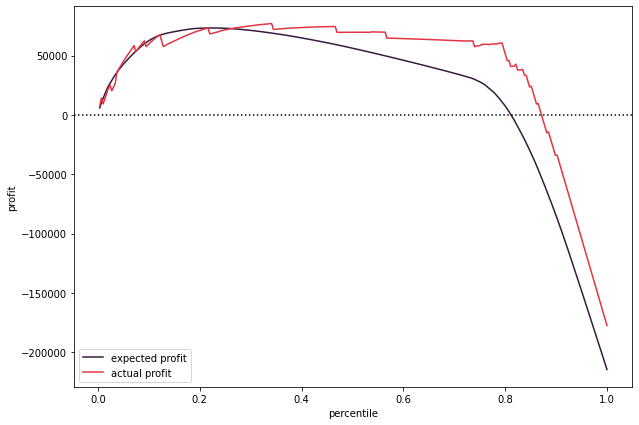

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_simulated_profit(sp):    
    f, a = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(#data=sp,
        x=sp.perc, y=sp.cecp, legend=False,
        color=sns.color_palette("rocket")[0], ax=a);
    sns.lineplot(#data=sp,
        x=sp.perc, y=sp.cacp, legend=False,
        color=sns.color_palette("rocket")[3], ax=a);
    a.set_ylabel("profit");
    a.set_xlabel("percentile");
    a.legend(loc="lower left",
        labels=["expected profit", "actual profit"]);
    a.axhline(0, linestyle="dotted", c="k");
    return None
plot_simulated_profit(sp)    